In [3]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

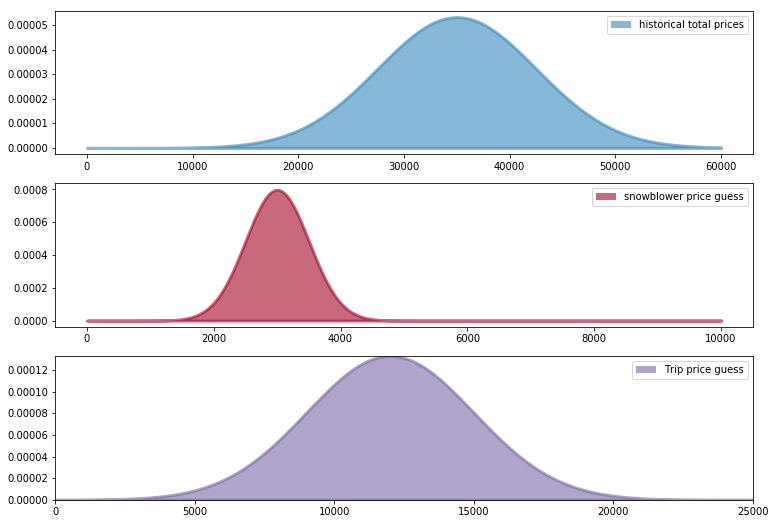

In [2]:
figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500), 
                color = "#348ABD", lw = 3, alpha = 0.6,
                label = "historical total prices")
p1 = plt.Rectangle((0,0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500), 
                 color = "#A60628", lw = 3, alpha = 0.6,
                 label="snowblower price guess")

p2 = plt.Rectangle((0,0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                color = "#7A68A6", lw = 3, alpha = 0.6,
                label = "Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0,0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()])

In [4]:
data_mu = [3e3, 12e3]

data_std = [5e2, 3e3]

mu_prior = 35e3
std_prior = 75e2

with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)
    
    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]
    
price_trace = burned_trace["true_price"]

100%|██████████| 50500/50500 [00:17<00:00, 2813.42it/s]


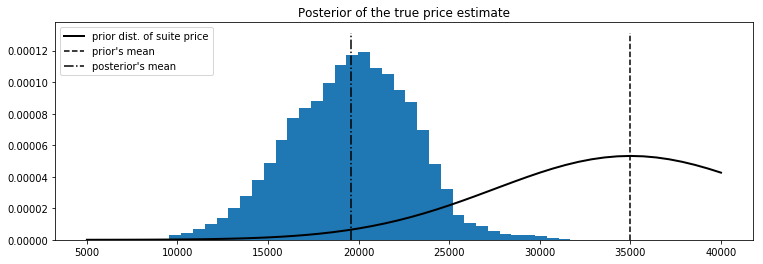

In [5]:
figsize(12.5, 4)

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, label = "prior dist. of suite price")

_hist = plt.hist(price_trace, bins=35, normed=True, histtype="stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label="prior's mean", linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), label="posterior's mean", linestyles="-.")
plt.legend(loc="upper left")

In [16]:
help(pm.distributions.distribution.Distribution)

Help on class Distribution in module pymc3.distributions.distribution:

class Distribution(builtins.object)
 |  Statistical distribution
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |  
 |  __init__(self, shape, dtype, testval=None, defaults=(), transform=None, broadcastable=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  default(self)
 |  
 |  get_test_val(self, val, defaults)
 |  
 |  getattr_value(self, val)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  dist(*args, **kwargs) from builtins.type
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(cls, name, *args, **kwargs)
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict

In [15]:
help(pm.distributions.distribution.Bounded)

Help on class Bounded in module pymc3.distributions.distribution:

class Bounded(Distribution)
 |  An upper, lower or upper+lower bounded distribution
 |  
 |  Parameters
 |  ----------
 |  distribution : pymc3 distribution
 |      Distribution to be transformed into a bounded distribution
 |  lower : float (optional)
 |      Lower bound of the distribution, set to -inf to disable.
 |  upper : float (optional)
 |      Upper bound of the distribibution, set to inf to disable.
 |  tranform : 'infer' or object
 |      If 'infer', infers the right transform to apply from the supplied bounds.
 |      If transform object, has to supply .forward() and .backward() methods.
 |      See pymc3.distributions.transforms for more information.
 |  
 |  Method resolution order:
 |      Bounded
 |      Distribution
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, distribution, lower, upper, transform='infer', *args, **kwargs)
 |      Initialize self.  See help(type(self)) 

In [14]:
help(pm.Potential)

Help on function Potential in module pymc3.model:

Potential(name, var, model=None)
    Add an arbitrary factor potential to the model likelihood
    
    Parameters
    ----------
    name : str
    var : theano variables
    
    Returns
    -------
    var : var, with name attribute



(5000, 30000)

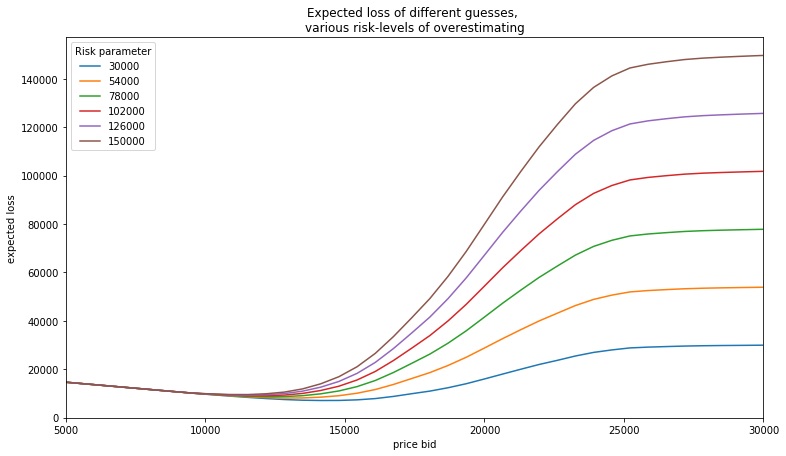

In [19]:
figsize(12.5, 7)

def showdown_loss(guess, true_price, risk=80000):
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    loss[~ix] = np.abs(guess - true_price[~ix])
    close_mask = [abs(true_price - guess) <= 250]
    loss[close_mask] = -2*true_price[close_mask]
    loss[ix] = risk
    return loss

guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)

plt.title("Expected loss of different guesses, \nvarious risk-levels of overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000)

minimum at risk 30000: 14495.33
minimum at risk 54000: 12905.75
minimum at risk 78000: 12636.48
minimum at risk 102000: 11673.94
minimum at risk 126000: 11662.52
minimum at risk 150000: 11339.96


(-1000, 80000)

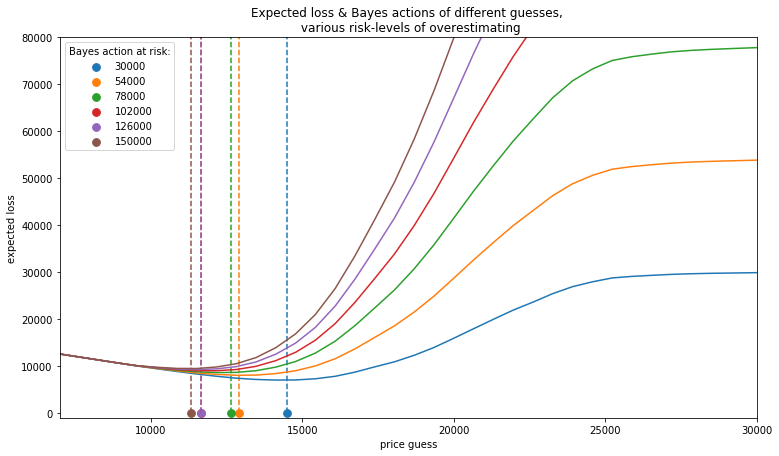

In [20]:
import scipy.optimize as sop

ax = plt.subplot(111)

for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,), disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results, color=_color['color'])
    plt.scatter(_min_results, 0, s = 60, color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))

plt.title("Expected loss & Bayes actions of different guesses, \n various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints = 1, title = "Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000)

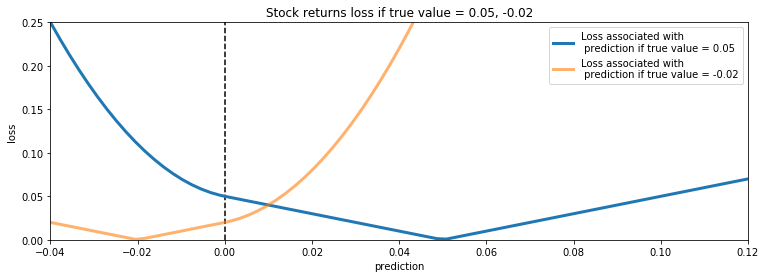

In [23]:
figsize(12.5, 4)

def stock_loss(true_return, yhat, alpha=100):
    if true_return * yhat < 0:
        return alpha * yhat**2 - np.sign(true_return)*yhat + abs(true_return)
    else:
        return abs(true_return - yhat)

true_value = 0.05
pred = np.linspace(-0.04, 0.12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], label = "Loss associated with\n prediction if true value = 0.05", lw =3)
plt.vlines(0, 0, 0.25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, 0.12)
plt.ylim(0, 0.25)

true_value = -0.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha = 0.6, label = "Loss associated with\n prediction if true value = -0.02", lw =3)
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02")

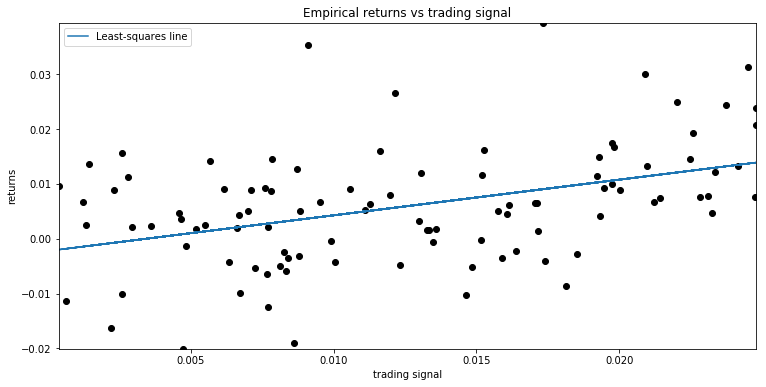

In [36]:
## Code to create artificial data
N = 100
X = 0.025*np.random.rand(N)
Y = 0.5*X + 0.01*np.random.randn(N)

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X+ls_intercept, label="Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left")

In [37]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    
    mean = pm.Deterministic("mean", alpha + beta*X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]

100%|██████████| 100500/100500 [00:40<00:00, 2512.34it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x112ee9c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x126515ef0>], dtype=object)

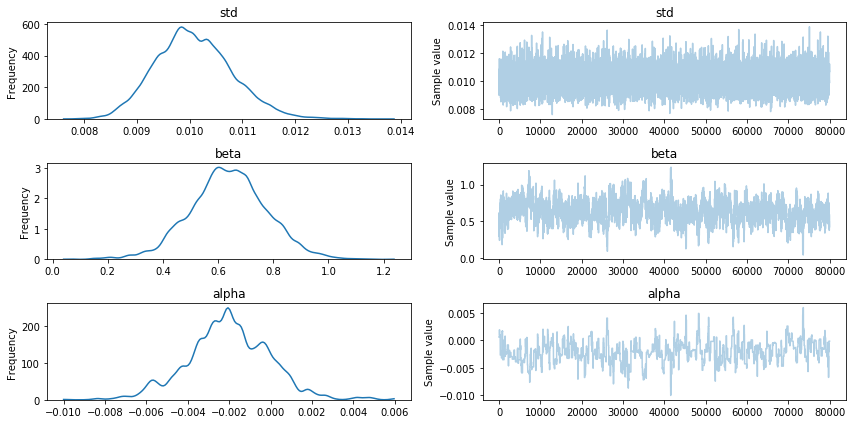

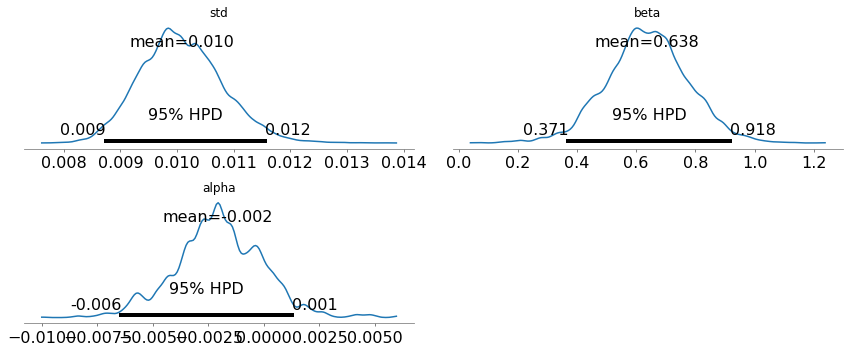

In [38]:
pm.plots.traceplot(trace=burned_trace, varnames=["std", "beta", "alpha"])
pm.plot_posterior(trace=burned_trace, varnames=["std", "beta", "alpha"], kde_plot=True)

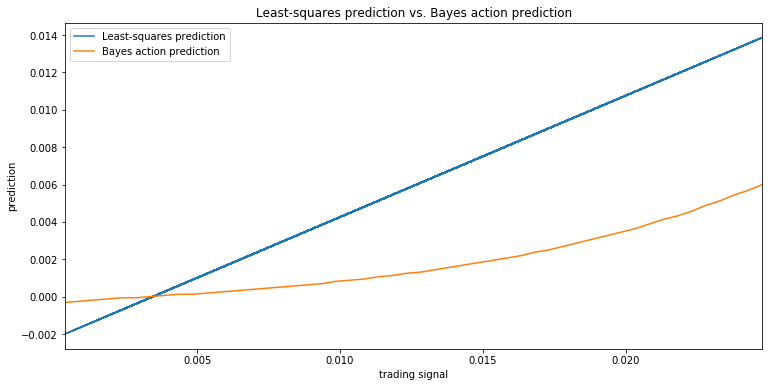

In [40]:
figsize(12.5, 6)
from scipy.optimize import fmin

def stock_loss(price, pred, coef=500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise

opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp = False)

plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
plt.legend(loc="upper left")

In [41]:
help(np.random.randn)

Help on built-in function randn:

randn(...) method of mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    If positive, int_like or int-convertible arguments are provided,
    `randn` generates an array of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1 (if any of the :math:`d_i` are
    floats, they are first converted to integers by truncation). A single
    float randomly sampled from the distribution is returned if no
    argument is provided.
    
    This is a convenience function.  If you want an interface that takes a
    tuple as the first argument, use `numpy.random.standard_normal` instead.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, should be all positive.
        If no argument is given a single Python float is ret

In [45]:
from os import makedirs
from urllib.request import urlretrieve

makedirs("data/Train_Skies/Train_Skies/", exist_ok=True)

urlretrieve("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/draw_sky2.py", "draw_sky2.py")
urlretrieve("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/data/Train_Skies/Train_Skies/Training_Sky3.csv", "data/Train_Skies/Train_Skies/Training_Sky3.csv")

('data/Train_Skies/Train_Skies/Training_Sky3.csv',
 <http.client.HTTPMessage at 0x11f3045f8>)

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[  1.62690000e+02   1.60006000e+03   1.14664000e-01  -1.90326000e-01]
 [  2.27228000e+03   5.40040000e+02   6.23555000e-01   2.14979000e-01]
 [  3.55364000e+03   2.69771000e+03   2.83527000e-01  -3.01870000e-01]]


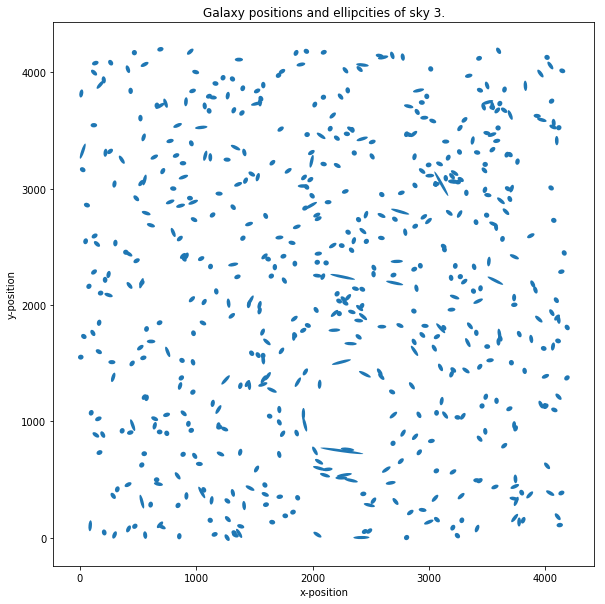

In [46]:
from draw_sky2 import draw_sky

n_sky = 3
data = np.genfromtxt("data/Train_Skies/Train_Skies/Training_Sky%d.csv" % (n_sky), dtype=None, skip_header=1, delimiter=",", usecols=[1,2,3,4])
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

In [48]:
import theano.tensor as T

def euclidean_distance(x, y):
    return np.sqrt((x-y)**2).sum(axis=1)

def f_distance(gxy_pos, halo_pos, c):
    return T.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    delta = glxy_position - halo_position
    t = (2*T.arctan(delta[:,1]/delta[:,0]))
    return T.stack([-T.cos(t), -T.sin(t)], axis=1)

with pm.Model() as model:
    #set the size of the halo's mass
    mass_large = pm.Uniform("mass_large", 40, 180)
    
    #set the initial prior position of the halos, it's a 2-d Uniform dist.
    halo_position = pm.Uniform("halo_position", 0, 4200, shape=(1,2))
    
    mean = pm.Deterministic("mean", mass_large / \
                            f_distance(T.as_tensor(data[:, :2]), halo_position, 240) *\
                            tangential_distance(T.as_tensor(data[:,:2]), halo_position))
    
    ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])

In [49]:
with model:
    mu, sds, elbo = pm.variational.advi(n=50000)
    step = pm.NUTS(scaling=model.dict_to_arrayto_array(sds), is_cov=True)
    trace = pm.sample(5000, step=step, start=mu)

/Users/yusuke/anaconda/envs/pymc3/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  
Average ELBO = 146.43:  66%|██████▌   | 32774/50000 [00:08<00:04, 3940.26it/s]Median ELBO converged.
Finished [100%]: Average ELBO = 148.6

100%|██████████| 5500/5500 [00:30<00:00, 178.13it/s]


(0, 4200)

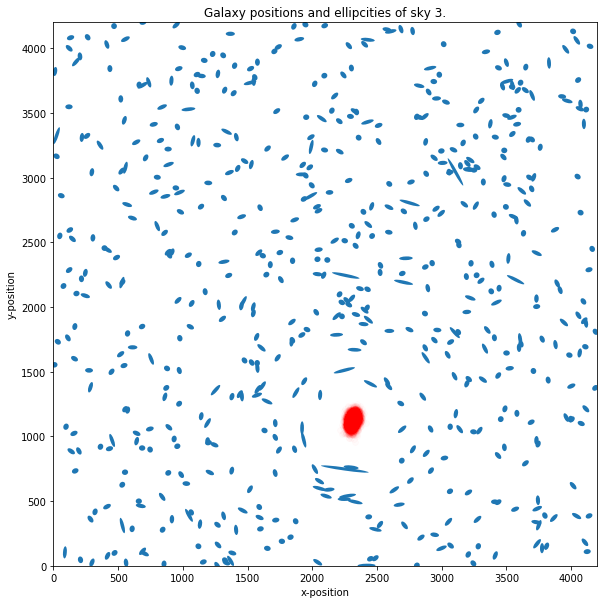

In [50]:
t = trace["halo_position"].reshape(5000, 2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha=0.015, c="r")
plt.xlim(0, 4200)
plt.ylim(0, 4200)

In [51]:
urlretrieve("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/data/Training_halos.csv", "data/Training_halos.csv")

('data/Training_halos.csv', <http.client.HTTPMessage at 0x123cb2198>)

In [52]:
halo_data = np.genfromtxt("data/Training_halos.csv", delimiter=",", usecols=[1,2,3,4,5,6,7,8,9], skip_header=1)
print(halo_data[n_sky])

[  1.00000000e+00   1.40861000e+03   1.68586000e+03   1.40861000e+03
   1.68586000e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


True halo location: 1408.61 1685.86


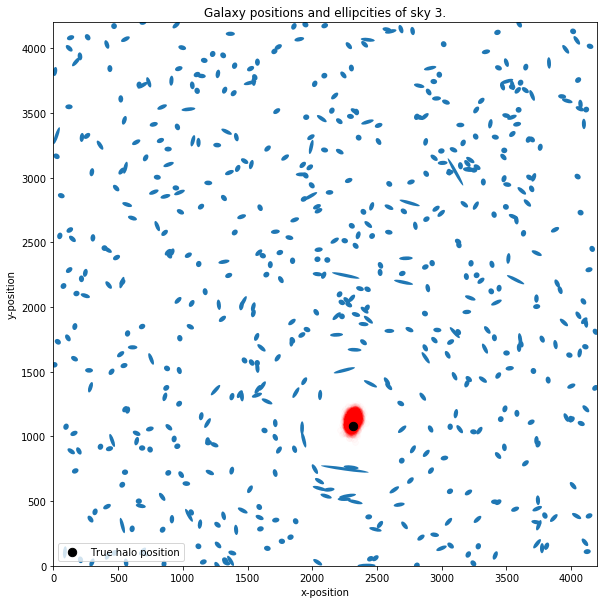

In [53]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha=0.015, c="r")
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4], label="True halo position", c="k", s=70)
plt.legend(scatterpoints=1, loc="lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200)

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

In [54]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print(mean_posterior)

[[ 2312.38017488  1127.04733826]]


In [55]:
urlretrieve("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/DarkWorldsMetric.py", "DarkWorldsMetric.py")

('DarkWorldsMetric.py', <http.client.HTTPMessage at 0x123fa79b0>)

In [56]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky - 1]

nhalo_all = _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, random_guess)

Using the mean:
Your average distance in pixels you are away from the true halo is 45.2253107101
Your average angular vector is 1.0
Your score for the training data is 1.04522531071
Using a random location: [[4039 3786]]
Your average distance in pixels you are away from the true halo is 3206.45810372
Your average angular vector is 1.0
Your score for the training data is 4.20645810372


4.2064581037181821

In [62]:
def halo_posteriors(n_halos_in_sky, galaxy_data, samples=5e5, burn_in=500):
    #set the size of the halo's mass
    with pm.Model() as model:
        mass_large = pm.Uniform("mass_large", 40, 180)
        
        mass_small_1 = 20
        mass_small_2 = 20
        
        masses = np.array([mass_large, mass_small_1, mass_small_2], dtype=object)
        
        #set the initial prior positions of the halos, it's a 2-d Uniform dist.
        halo_positions = pm.Uniform("halo_positions", 0, 4200, shape=(n_halos_in_sky, 2)) # notice the size
        
        fdist_constants = np.array([240, 70, 70])
        
        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += masses[i] / f_distance(data[:,:2], halo_positions[i,:], fdist_constants[i]) * tangential_distance(data[:,:2], halo_positions[i,:])
        
        mean = pm.Deterministic("mean", _sum)
        
        ellpty = pm.Normal("ellipcity", mu=mean, tau=1/0.05, observed=data[:,2:])
        
        mu, sds, elbo = pm.variational.advi(n=50000)
        step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
        trace = pm.sample(samples, step=step, start=mu)
    
    burned_trace = trace[burn_in:]
    return burned_trace["halo_positions"]

In [59]:
urlretrieve("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/data/Train_Skies/Train_Skies/Training_Sky215.csv", "data/Train_Skies/Train_Skies/Training_Sky215.csv")

('data/Train_Skies/Train_Skies/Training_Sky215.csv',
 <http.client.HTTPMessage at 0x124943fd0>)

In [60]:
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Train_Skies/Training_Sky%d.csv" % (n_sky), dtype=None, skip_header=1, delimiter=",", usecols=[1,2,3,4])

In [63]:
#there are 3 halos in this file. 
samples = 5000
trace = halo_posteriors(3, data, samples=samples, burn_in=500)

/Users/yusuke/anaconda/envs/pymc3/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
Average ELBO = 134.43: 100%|██████████| 50000/50000 [00:24<00:00, 2070.57it/s]
Finished [100%]: Average ELBO = 134.39
100%|█████████▉| 5499/5500 [14:57<00:00,  4.77it/s] /Users/yusuke/anaconda/envs/pymc3/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 6 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5500/5500 [14:57<00:00,  6.13it/s]


(0, 4200)

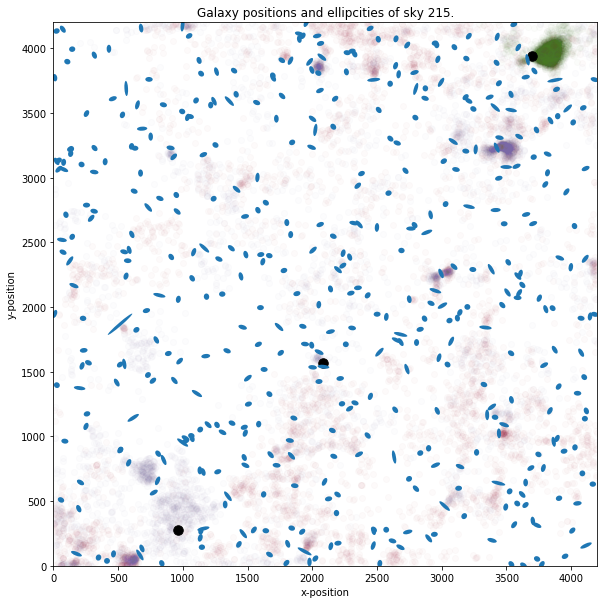

In [65]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(trace.shape[1]):
    plt.scatter(trace[:, i, 0], trace[:, i, 1], c = colors[i], alpha=0.02)

for i in range(trace.shape[1]):
    plt.scatter(halo_data[n_sky-1][3+2*i], halo_data[n_sky-1][4+2*i], label="True halo position", c = "k", s = 90)

plt.xlim(0, 4200)
plt.ylim(0, 4200)

In [67]:
_halo_data = halo_data[n_sky-1]
print(trace.shape)

mean_poterior = trace.mean(axis=0).reshape(1,6)
print(mean_posterior)

nhalo_all = _halo_data[0].reshape(1,1)
y_true_all = _halo_data[3].reshape(1,1)
x_ref_all = _halo_data[4].reshape(1,1)
y_ref_all = _halo_data[1].reshape(1,1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score([1], x_true_all, y_true_all, x_ref_all, y_ref_all, sky_prediction)
print("Using a random location:", random_guess)
main_score([1], x_true_all, y_true_all, x_ref_all, y_ref_all, random_guess)

(4500, 3, 2)
[[ 2312.38017488  1127.04733826]]
Using the mean:
Your average distance in pixels you are away from the true halo is 2569.39491107
Your average angular vector is 1.0
Your score for the training data is 3.56939491107
Using a random location: [[4039 3786]]
Your average distance in pixels you are away from the true halo is 1725.54575772
Your average angular vector is 1.0
Your score for the training data is 2.72554575772


2.7255457577242046